In [262]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import os 
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [9]:
DATA_PATH = './'
TRAIN_PATH = os.path.join(DATA_PATH, 'assignment_train.csv')
TEST_PATH = os.path.join(DATA_PATH, 'assignment_test.csv')
TARGET_COLUMN = 'isFraud'

## Задание на повторение

In [7]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 50001 rows, 394 cols
test.shape = 75000 rows, 394 cols


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 150.3+ MB


In [12]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
print(f'Всего в тренировочном датасете пропущенных значений: {train.isna().values.sum()}')
print(f'Всего в тестовом датасете пропущенных значений: {test.isna().values.sum()}')

Всего в тренировочном датасете пропущенных значений: 8247489
Всего в тестовом датасете пропущенных значений: 11156120


In [36]:
train.iloc[:, 0:17].head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN


<AxesSubplot:>

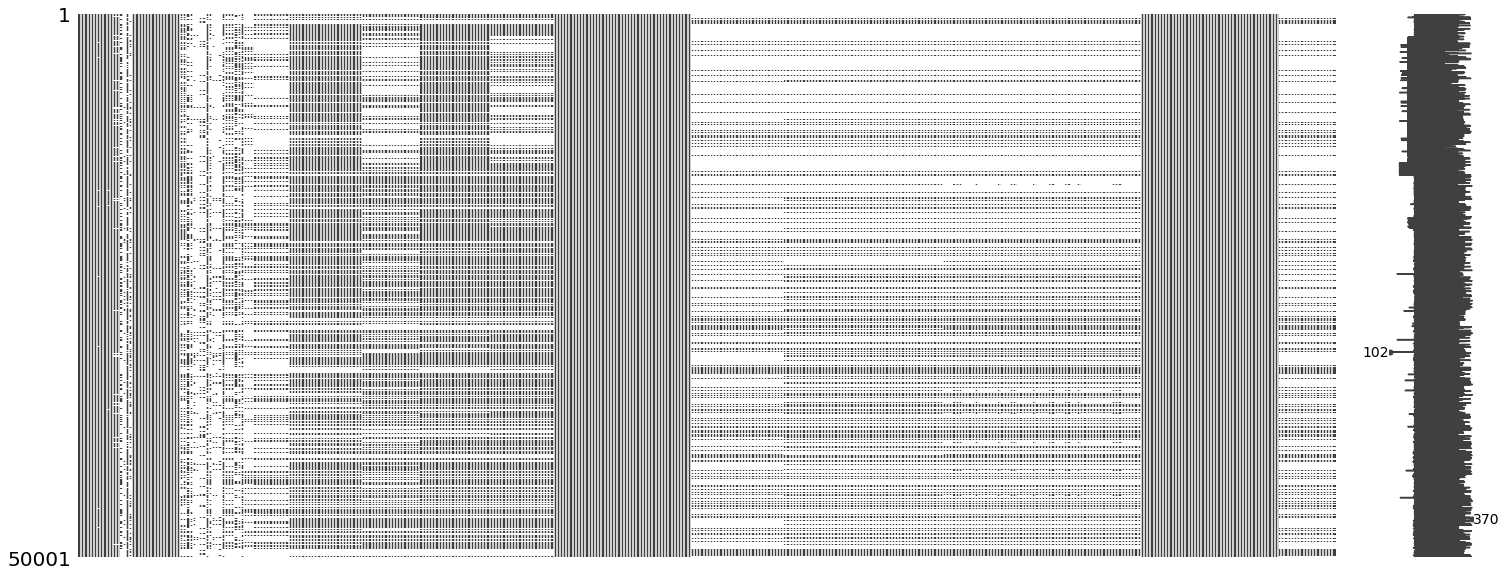

In [15]:
msno.matrix(train)

<AxesSubplot:>

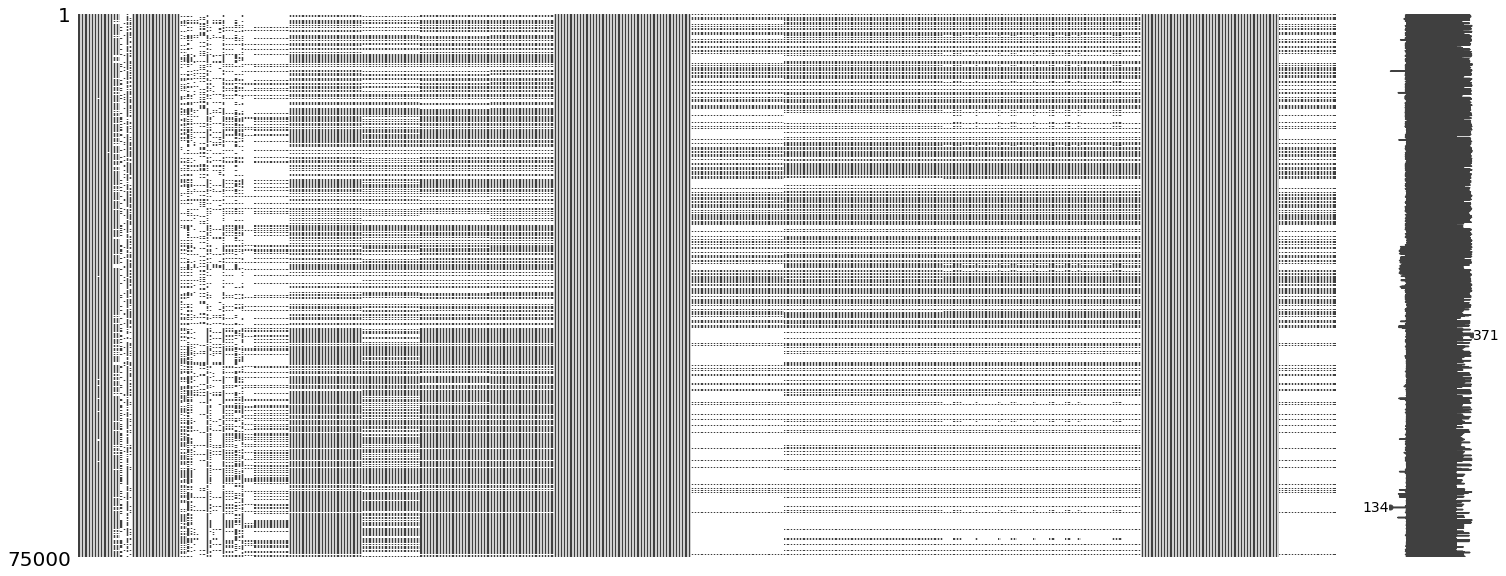

In [18]:
msno.matrix(test)

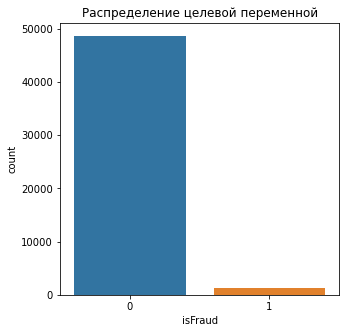

In [38]:
target = train[TARGET_COLUMN]
fig = plt.figure(figsize=(5, 5))
sns.countplot(x=TARGET_COLUMN, data=train)
plt.title('Распределение целевой переменной')
plt.show()

### Задание 1.1

Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

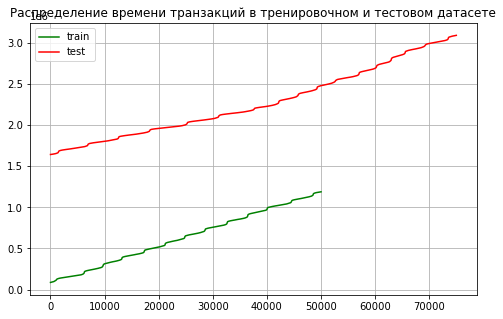

In [41]:
fig = plt.figure(figsize=(8, 5))

plt.plot(train['TransactionDT'], color='green', label='train')
plt.plot(test['TransactionDT'], color='red', label='test')
plt.grid()
plt.title('Распределение времени транзакций в тренировочном и тестовом датасете')
plt.legend()
plt.show()

**ВЫВОД**

1. Тест содержит больше записей, чем трейн
2. Оба датасета содержат достаточно большое количество пропусков и, судя по матрице, имеют одинаковые полностью заполненные признаки
3. Датасет очень сильно разбалансирован, что характерно для задачи определения мошеннических операций
4. По распределению времени видно, что:
    * Оно строго возрастает, то есть данные разбиты в хронологическом порядке 
    * В тесте данные присутствуют за более поздний период времени 
    * Между трейном и тестом присутствует отрезок времени, на котором отсутствуют какие-либо транзакции (при условии, что способ задания времени при формировании датасетов не менялся между трейном и тестом)
    
Так как данные, судя по приведенному выше анализу, содержат в себе временной признак, более того, время тренировочного и тестового датасетов не пересекается, можно построить валидацию с учетом времени. Также хотелось бы получить информацию о клиенте и, возможно, разделить датасет на основе этих знаний. Первая мысль, как, хотя бы приближенно, идентифицировать клиента (хотя в датасете отсутствует clientID) - это воспользоваться данными о карточке (категориальные признаки card1-card6).  

### Задание 1.2

построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

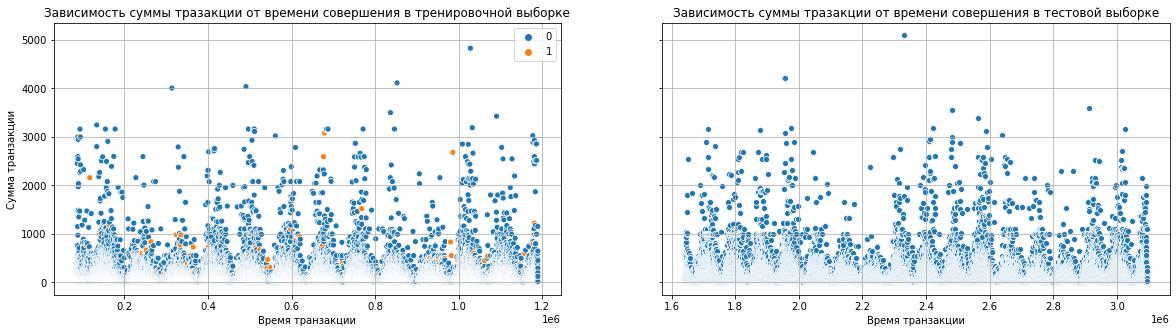

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
axes = axes.flatten()

sns.scatterplot(train['TransactionDT'].values, train['TransactionAmt'].values, hue=train['isFraud'].values, 
                ax=axes[0])
axes[0].set_title('Зависимость суммы тразакции от времени совершения в тренировочной выборке')
axes[0].set_ylabel('Сумма транзакции')
axes[0].set_xlabel('Время транзакции')
axes[0].grid()


sns.scatterplot(test['TransactionDT'].values, test['TransactionAmt'].values, ax=axes[1])
axes[1].set_title('Зависимость суммы тразакции от времени совершения в тестовой выборке')
axes[1].set_xlabel('Время транзакции')
axes[1].grid()

plt.show()

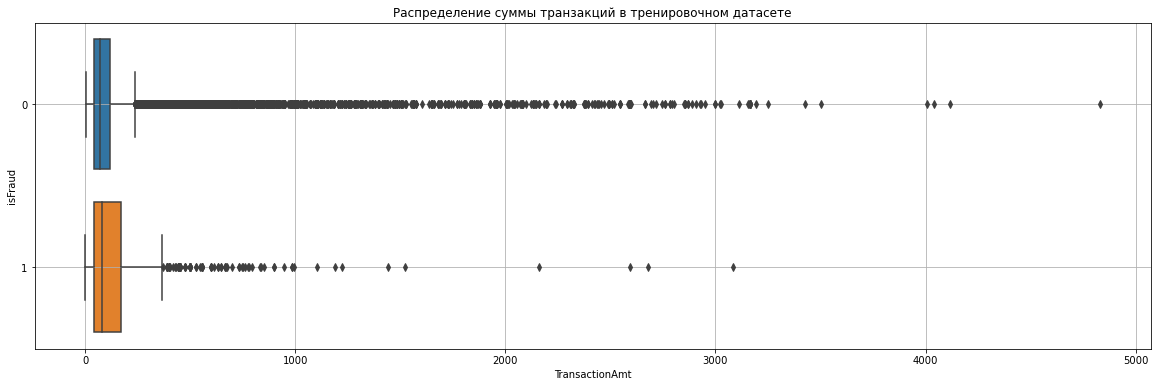

In [75]:
fig = plt.figure(figsize=(20, 6))
sns.boxplot(train['TransactionAmt'], train['isFraud'], orient='h')

plt.title('Распределение суммы транзакций в тренировочном датасете')
plt.grid()
plt.show()

**ВЫВОД**

* В данных видно проявление признаков временного ряда (сезонность), что подтверждает теорию о построении валидации с учетом времени
* Мошенничества на крупные суммы (больше 500 долларов) совершаются очень редко, хотя в среднем мошенническая транзакция несколько выше по объему средств, чем обычная

### Задание 1.3

построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

In [93]:
from scipy import stats
from scipy.stats import norm

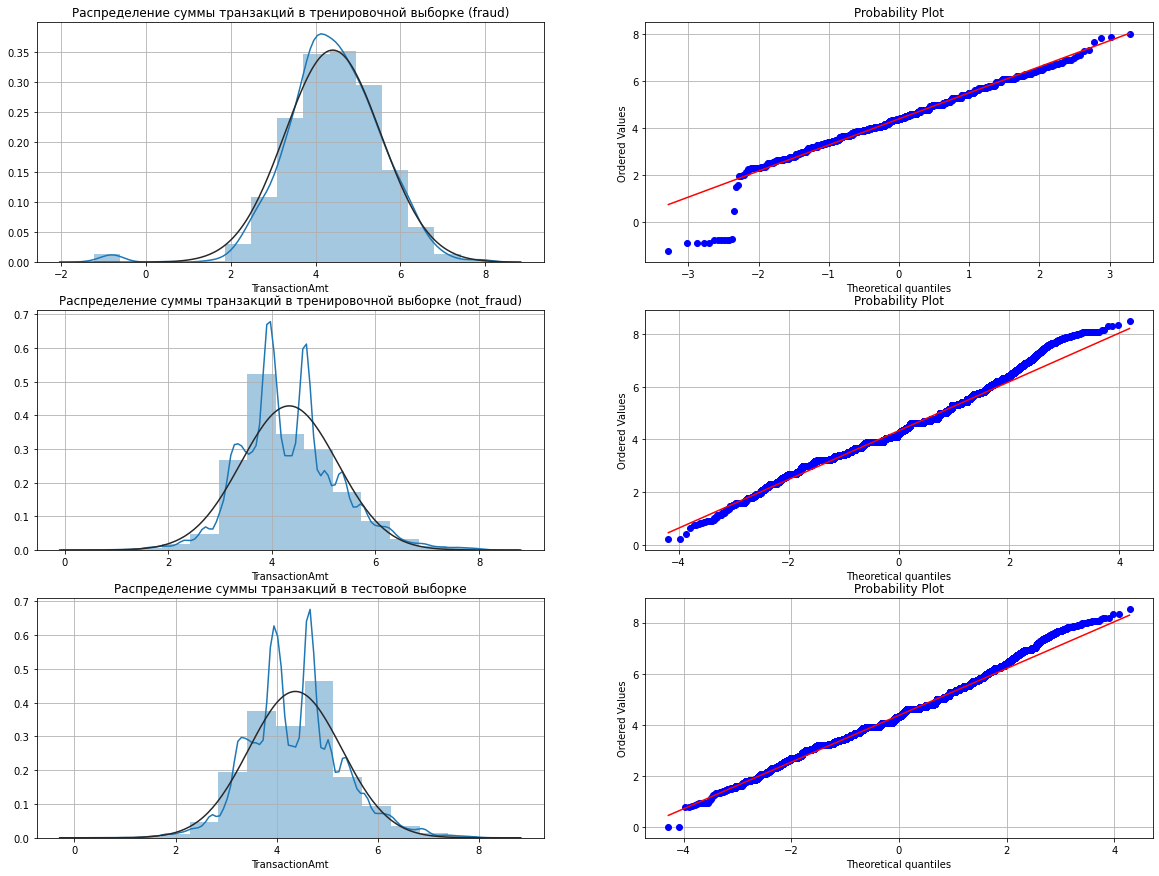

In [97]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

train_x_fraud = train.loc[train['isFraud'] == 1, 'TransactionAmt'].apply(np.log)
train_x_not_fraud = train.loc[train['isFraud'] == 0, 'TransactionAmt'].apply(np.log)
test_x = test['TransactionAmt'].apply(np.log)

comment = {0: 'тренировочной выборке (fraud)',
           1: 'тренировочной выборке (not_fraud)',
           2: 'тестовой выборке'
          }


for num, x_data in enumerate([train_x_fraud, train_x_not_fraud, test_x]):
    sns.distplot(x_data, bins=15, ax=axes[num, 0], fit=norm)
    title = 'Распределение суммы транзакций в ' + comment[num]
    axes[num, 0].set_title(title)
    
    stats.probplot(x_data, dist='norm', plot=axes[num, 1])
    axes[num, 0].grid()
    axes[num, 1].grid()


**ВЫВОД**

Данные о сумме транзакции, как и многие данные связанные с деньгами, имеют близкое к логнормальному распределение. Тем не менее по Q-Q графикам видны отклонения на концах отрезков и несмного шумное поведение вдоль прямой.

### Задание 1.4

построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

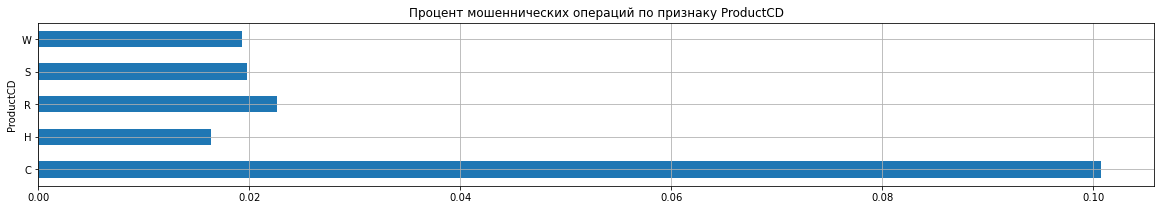

In [101]:
train.groupby('ProductCD')['isFraud'].mean()\
    .plot(kind='barh',
          figsize=(20, 3),
          title='Процент мошеннических операций по признаку ProductCD')
plt.grid()
plt.show()

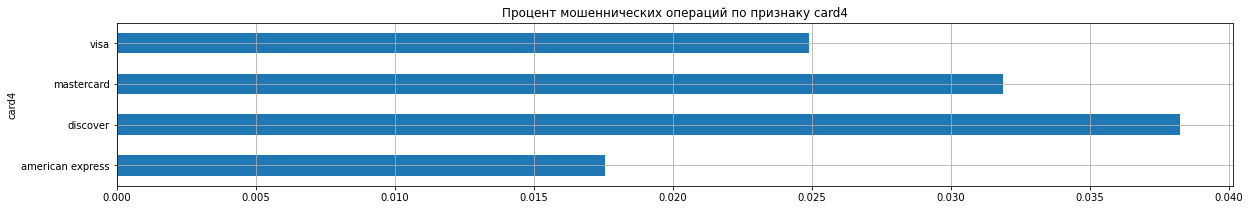

In [104]:
train.groupby('card4')['isFraud'].mean()\
    .plot(kind='barh',
          figsize=(20, 3),
          title='Процент мошеннических операций по признаку card4')
plt.grid()
plt.show()

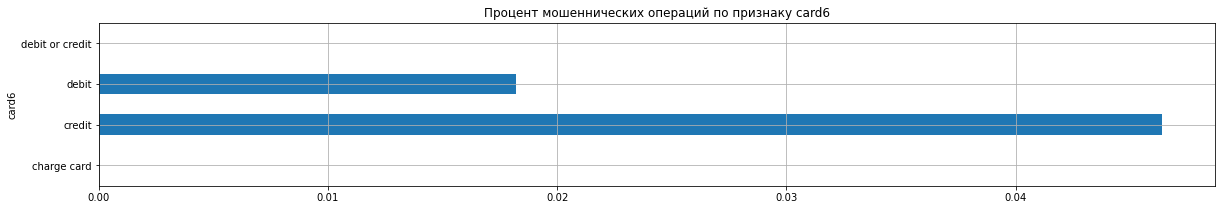

In [105]:
train.groupby('card6')['isFraud'].mean()\
    .plot(kind='barh',
          figsize=(20, 3),
          title='Процент мошеннических операций по признаку card6')
plt.grid()
plt.show()

In [107]:
train.groupby('card6')['TransactionID'].count()

card6
charge card            3
credit             15786
debit              34206
debit or credit        3
Name: TransactionID, dtype: int64

**ВЫВОД**

* Из первого графика видно, что для категории 'C' процент мошеннических операций сильно выше (примерно в 5 раз), чем для остальных
* Также самый высокий процент мошеннических операций происходит по картам типа discover, самый низкий - american express
* Больше мошеннических операций совершается по кредиткам, чем по дебетовым картам, при этом для типов debit or credit и charge card наблюдаем 0 процент мошенничества. Это было бы неплохим разделяющим признаком, если бы такие типы карт были хоть как-то распространены в датасете. В нашем случае, суммарное количество транзакций с такими типами карт - 6

## Основное задание

Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая.

### Задание 2.1

сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

**Комментарий**

В данных довольно много пропусков, поэтому принял решения воспользоваться бустингом, который умеет автоматически их обрабатывать. Также присутствуют категориальные признаки, с которыми необходимо работать. Остановился на catboost

In [403]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [404]:
public_test_x = test.drop(["TransactionID", "TransactionDT", TARGET_COLUMN], axis=1)
public_test_y = test[TARGET_COLUMN]

In [405]:
cat_features = x_train.select_dtypes("object").columns.tolist()
cat_features

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [406]:
public_test_x[cat_features] = public_test_x[cat_features].fillna('NaN')
train[cat_features] = train[cat_features].fillna('NaN')

In [407]:
public_test_x[cat_features] = public_test_x[cat_features].astype(str)
train[cat_features] = train[cat_features].astype(str)

In [408]:
params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'task_type': 'CPU',
    'max_bin': 20,
    'max_depth': 6,
    'l2_leaf_reg': 100,
    'early_stopping_rounds': 50,
    'thread_count': 6,
    'random_seed': 27
}

In [412]:
# Так как было показано выше, что время в тестовой выборке не пересекается, для разбиения на трейн и тест 
# параметр shuffle установлен False, по сути это реализация задания 6* так как здесь не нарушается временная структура
# и в тест попадают данные за более поздний период чем в трейне, при этом временные интервалы не пересекаются

for train_size in np.arange(0.65, 0.9, 0.05):
    x_train, x_test = train_test_split(
        train.drop(["TransactionID", "TransactionDT", TARGET_COLUMN], axis=1), train_size=train_size, shuffle=False
    )
    y_train, y_test = train_test_split(
        train[TARGET_COLUMN], train_size=train_size, shuffle=False
    )
    
    model = catb.CatBoostClassifier(**params)
    model.fit(x_train, y_train, cat_features=cat_features, 
              eval_set=[(x_train, y_train), (x_test, y_test)], verbose=0)
    
    train_score = roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])
    test_score = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    public_test_score = roc_auc_score(public_test_y, model.predict_proba(public_test_x)[:, 1])
    
    np.random.seed(27)
    scores = create_bootstrap_metrics(y_test, model.predict_proba(x_test)[:, 1], roc_auc_score)
    ci = calculate_confidence_interval(scores)
    is_metric_inside = True if (public_test_score > ci[0]) and (public_test_score < ci[1]) else False 

    print(f"Train-size: {round(train_size, 2)}, Train-score: {round(train_score, 3)}, "\
          f"Test-score: {round(test_score, 3)}, Public test-score: {round(public_test_score, 3)}, "\
          f"CI: ({round(ci[0], 3)}, {round(ci[1], 3)}), {is_metric_inside}")

Train-size: 0.65, Train-score: 0.888, Test-score: 0.879, Public test-score: 0.865, CI: (0.86, 0.898), True
Train-size: 0.7, Train-score: 0.885, Test-score: 0.884, Public test-score: 0.864, CI: (0.865, 0.903), False
Train-size: 0.75, Train-score: 0.885, Test-score: 0.884, Public test-score: 0.866, CI: (0.862, 0.906), True
Train-size: 0.8, Train-score: 0.886, Test-score: 0.892, Public test-score: 0.867, CI: (0.867, 0.914), False
Train-size: 0.85, Train-score: 0.892, Test-score: 0.872, Public test-score: 0.868, CI: (0.836, 0.905), True


**ВЫВОД**

Использование разбиений с сохранением временной структуры, не перемешивая данные, дает не очень стабильные результаты: несмотря на то, что скоры на трейне и тесте достаточно близки друг к другу, скор на публичном лидер борде не всегда попадает в доверительный интервал. Ширина интервала выглядит допустимой 3-5%, но надежно валидироваться таким способом не получится. Попробую использовать параметр shuffle равный True

In [413]:
for train_size in np.arange(0.65, 0.9, 0.05):
    x_train, x_test = train_test_split(
        train.drop(["TransactionID",'TransactionDT', TARGET_COLUMN], axis=1), train_size=train_size, shuffle=True, 
        random_state=27,
    )
    y_train, y_test = train_test_split(
        train[TARGET_COLUMN], train_size=train_size, shuffle=True, random_state=27,
    )
    
    model = catb.CatBoostClassifier(**params)
    model.fit(X=x_train, y=y_train, cat_features=cat_features, 
              eval_set=[(x_train, y_train), (x_test, y_test)], verbose=0)
    
    train_score = roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])
    test_score = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    public_test_score = roc_auc_score(public_test_y, model.predict_proba(public_test_x)[:, 1])
    
    np.random.seed(27)
    scores = create_bootstrap_metrics(y_test, model.predict_proba(x_test)[:, 1], roc_auc_score)
    ci = calculate_confidence_interval(scores)
    is_metric_inside = True if (public_test_score > ci[0]) and (public_test_score < ci[1]) else False 

    print(f"Train-size: {round(train_size, 2)}, Train-score: {round(train_score, 3)}, "\
          f"Test-score: {round(test_score, 3)}, Public test-score: {round(public_test_score, 3)}, "\
          f"CI: ({round(ci[0], 3)}, {round(ci[1], 3)}), {is_metric_inside}")

Train-size: 0.65, Train-score: 0.897, Test-score: 0.872, Public test-score: 0.867, CI: (0.851, 0.892), True
Train-size: 0.7, Train-score: 0.896, Test-score: 0.869, Public test-score: 0.866, CI: (0.846, 0.891), True
Train-size: 0.75, Train-score: 0.893, Test-score: 0.866, Public test-score: 0.864, CI: (0.84, 0.89), True
Train-size: 0.8, Train-score: 0.891, Test-score: 0.87, Public test-score: 0.867, CI: (0.841, 0.895), True
Train-size: 0.85, Train-score: 0.89, Test-score: 0.878, Public test-score: 0.867, CI: (0.849, 0.905), True


In [414]:
# Добавил stratify

for train_size in np.arange(0.65, 0.9, 0.05):
    x_train, x_test = train_test_split(
        train.drop(["TransactionID", 'TransactionDT', TARGET_COLUMN], axis=1), train_size=train_size, shuffle=True, 
        random_state=1, stratify=train[TARGET_COLUMN].values
    )
    y_train, y_test = train_test_split(
        train[TARGET_COLUMN], train_size=train_size, shuffle=True, random_state=1,
        stratify=train[TARGET_COLUMN].values
    )
    
    model = catb.CatBoostClassifier(**params)
    model.fit(x_train, y_train, cat_features=cat_features, 
              eval_set=[(x_train, y_train), (x_test, y_test)], verbose=0)
    
    train_score = roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])
    test_score = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    public_test_score = roc_auc_score(public_test_y, model.predict_proba(public_test_x)[:, 1])
    
    np.random.seed(27)
    scores = create_bootstrap_metrics(y_test, model.predict_proba(x_test)[:, 1], roc_auc_score)
    ci = calculate_confidence_interval(scores)
    is_metric_inside = True if (public_test_score > ci[0]) and (public_test_score < ci[1]) else False 

    print(f"Train-size: {round(train_size, 2)}, Train-score: {round(train_score, 3)}, "\
          f"Test-score: {round(test_score, 3)}, Public test-score: {round(public_test_score, 3)}, "\
          f"CI: ({round(ci[0], 3)}, {round(ci[1], 3)}), {is_metric_inside}")

Train-size: 0.65, Train-score: 0.887, Test-score: 0.886, Public test-score: 0.865, CI: (0.867, 0.905), False
Train-size: 0.7, Train-score: 0.89, Test-score: 0.886, Public test-score: 0.866, CI: (0.867, 0.905), False
Train-size: 0.75, Train-score: 0.889, Test-score: 0.891, Public test-score: 0.867, CI: (0.87, 0.909), False
Train-size: 0.8, Train-score: 0.888, Test-score: 0.888, Public test-score: 0.867, CI: (0.863, 0.91), True
Train-size: 0.85, Train-score: 0.89, Test-score: 0.883, Public test-score: 0.867, CI: (0.853, 0.909), True


**ВЫВОД**

* Перемешанная выборка создает более репрезентативное разбиение, доверительный интервал находится в допустимых значениях (4-6%), видно небольшое переобучение на трейне (2-3%). При этом скор на публичном лидерборде стабильно попадает примерно в середину доверительного интервала. Схему валидации можно использовать далее. Для разбиения на три выборки возьмем первый случай 65-35 и далее разделеим валидационный и тестовый датасет пополам 50-50
* Использование параметра stratify завышает оценку качества модели на публичном лидерборде и дает стабильно более оптимистичный прогноз, чем он есть на самом деле. Это правило нарушается только для разбиения 80-20 и 85-25, где скор публичного лидерборда попадает в доверительный интервал, но находится очень близко к его нижней границе. В целом можно сделать вывод о том, что распределение отказов в трейне и тесте слегка различно из-за чего подобная схема валидации выглядит не очень хорошей.

### Задание 2.2

сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

In [503]:
x_train, x_valid = train_test_split(
    train.drop(["TransactionID", 'TransactionDT', TARGET_COLUMN], axis=1), 
    train_size=0.65, shuffle=True, random_state=1
)

y_train, y_valid = train_test_split(
    train[TARGET_COLUMN], train_size=0.65, shuffle=True, random_state=1,
)

x_valid, x_test = train_test_split(
    x_valid, train_size=0.5, shuffle=True, random_state=27
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.5, shuffle=True, random_state=27
)

model = catb.CatBoostClassifier(**params)
model.fit(x_train, y_train, cat_features=cat_features, 
          eval_set=[(x_train, y_train), (x_valid, y_valid)], verbose=0)

train_score = roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])
valid_score = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
test_score = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
public_test_score = roc_auc_score(public_test_y, model.predict_proba(public_test_x)[:, 1])

np.random.seed(27)
scores = create_bootstrap_metrics(y_test, model.predict_proba(x_test)[:, 1], roc_auc_score)
ci = calculate_confidence_interval(scores)
is_metric_inside = True if (public_test_score > ci[0]) and (public_test_score < ci[1]) else False 

print(f"Train-score: {round(train_score, 3)}, "\
      f"Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}, "\
      f"Public-lb-score: {round(public_test_score, 3)}, "\
      f"CI: ({round(ci[0], 3)}, {round(ci[1], 3)}), {is_metric_inside}")

Train-score: 0.886, Valid-score: 0.885, Test-score: 0.865, Public-lb-score: 0.865, CI: (0.839, 0.888), True


In [428]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(32500, 391)
(8750, 391)
(8751, 391)


**ВЫВОД**

В таком варианте разбиения схема валидации все еще валидна,оценка на паблике попадает примерно в середину интервала. Сам интервал остался примерно таким же по ширине по сравнению с вариантом на 2 выборки

### Задание 3

построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

(сделал в процессе первых 2)

### Задание 4

выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

In [504]:
x_adv = pd.concat([train.drop(columns=['TransactionID', 'TransactionDT']),
                  test.drop(columns=['TransactionID', 'TransactionDT'])],
                  axis=0
                 )
y_adv = np.hstack((np.zeros(train.shape[0]), np.ones(test.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [505]:
x_adv[cat_features] = x_adv[cat_features].fillna('NaN')

In [506]:
model = catb.CatBoostClassifier(n_estimators=200, learning_rate=0.05)
model.fit(x_adv, y_adv, cat_features=cat_features, verbose=0)

In [507]:
roc_auc_score(y_adv, model.predict_proba(x_adv)[:, 1])

0.8256935675953148

In [508]:
y_pred = model.predict_proba(train.drop(columns=['TransactionID', 'TransactionDT']))

In [509]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    14132
(0.1, 0.2]     1283
(0.2, 0.3]     2025
(0.3, 0.4]     2078
(0.4, 0.5]     3901
(0.5, 0.6]    10292
(0.6, 0.7]    10316
(0.7, 0.8]     3591
(0.8, 0.9]     2051
(0.9, 1.0]      332
dtype: int64

In [510]:
val_idx = np.where(y_pred[:, 1] > 0.625)[0]

In [511]:
val_idx.shape

(10314,)

In [516]:
x_test = train.iloc[val_idx]
y_test = x_test[TARGET_COLUMN]

x_train = train.iloc[~val_idx]
y_train = x_train[TARGET_COLUMN]

x_train.drop(columns=['TransactionID', 'TransactionDT', TARGET_COLUMN], inplace=True)
x_test.drop(columns=['TransactionID', 'TransactionDT', TARGET_COLUMN], inplace=True)



x_train, x_valid = train_test_split(
    x_train, 
    train_size=0.65, shuffle=True, random_state=27
)

y_train, y_valid = train_test_split(
    y_train, train_size=0.65, shuffle=True, random_state=27,
)

In [517]:
x_test.shape

(10314, 391)

In [518]:
model = catb.CatBoostClassifier(**params)
model.fit(x_train, y_train, cat_features=cat_features, 
          eval_set=[(x_train, y_train), (x_valid, y_valid)], verbose=0)

In [519]:
train_score = roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])
valid_score = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
test_score = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
public_test_score = roc_auc_score(public_test_y, model.predict_proba(public_test_x)[:, 1])

np.random.seed(27)
scores = create_bootstrap_metrics(y_test, model.predict_proba(x_test)[:, 1], roc_auc_score)
ci = calculate_confidence_interval(scores)
is_metric_inside = True if (public_test_score > ci[0]) and (public_test_score < ci[1]) else False 

print(
      f"Train-score: {round(train_score, 3)}, "\
      f"Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}, "\
      f"Public-lb-score: {round(public_test_score, 3)}, "\
      f"CI: ({round(ci[0], 2)}, {round(ci[1], 2)}), {is_metric_inside}")

Train-score: 0.876, Valid-score: 0.85, Test-score: 0.848, Public-lb-score: 0.846, CI: (0.82, 0.87), True


**ВЫВОД**

На основе Adversarial validation удалось сформировать тестовую выборку с объектами, похожими на публичный лидерборд. Классификатор получился достаточно сильным, что говорит о том, что, вероятно данные взяты из разных разбиений. По сравнению с hold-out валидацие на три выборке заметно небольшое расширение доверительного интервала, но оценка на паблике все еще попадает примерно в середину

### Задание 5

сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных;

In [524]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train, cat_features=cat_features, verbose=0, 
                      eval_set=(x_valid, y_valid))
        y_train_pred = estimator.predict_proba(x_train)[:, 1]
        y_valid_pred = estimator.predict_proba(x_valid)[:, 1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [525]:
model = catb.CatBoostClassifier(**params)

In [526]:
cv_strategy = KFold(n_splits=5, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train.drop(columns=['TransactionID', 'TransactionDT', TARGET_COLUMN]), train[TARGET_COLUMN], model, 
    metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.8965, valid-score = 0.842
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.8923, valid-score = 0.8657
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.8875, valid-score = 0.8906
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.8921, valid-score = 0.8729
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.8867, valid-score = 0.8916
CV-results train: 0.891 +/- 0.004
CV-results valid: 0.8726 +/- 0.018
OOF-score = 0.8705


In [527]:
y_pred_lb = 0
for estimator in estimators:
    y_pred_lb += estimator.predict_proba(public_test_x)[:, 1]
    
y_pred_lb = y_pred_lb / 5

In [528]:
public_test_score = roc_auc_score(public_test_y, 
                                  y_pred_lb)
public_test_score

0.8660486852154821

**ВЫВОД**

Результаты кроссвалидации на валидационных выборках достаточно устойчивы +/- 1.8%, что точнее, чем при hold-out валидации. Оценка на паблике также попала внутрь указанного диапазона. Схему можно считать валидной.